<a href="https://colab.research.google.com/github/rvraghvender/DeepLearningProjects/blob/main/ConvolutionNeuralNetworks/TransferLearning/TransferLearning_Transfer_learning_with_MobileNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with MobileNetV2

In this project, transfer learning will be used on a pre-trained CNN to build an **Alpaca/Not Alpaca** classifier.

<img src="https://github.com/rvraghvender/DeepLearningProjects/blob/main/ConvolutionNeuralNetworks/TransferLearning/images/alpaca.png?raw=true" style="width:300px;height:220px;">

A pre-trained model is a network that's already been trained on a large dataset and saved, which allows us to use it to customize our own model cheaply and efficiently. MobileNetV2, was designed to provide fast and computationally efficient performance. The model is pre-trained on ImageNet, a dataset containing over 14 million images and 1000 classes.

In [1]:
# importing relevant packages
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

## Create the dataset and split it into training and validation sets


In [2]:
# !unzip dataset.zip

In [3]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
directory = "dataset/"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)

validation_dataset = image_dataset_from_directory(directory,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE,
                                                  validation_split=0.2,
                                                  subset='validation',
                                                  seed=42)

Found 327 files belonging to 2 classes.
Using 262 files for training.
Found 327 files belonging to 2 classes.
Using 65 files for validation.


## Looking at the images

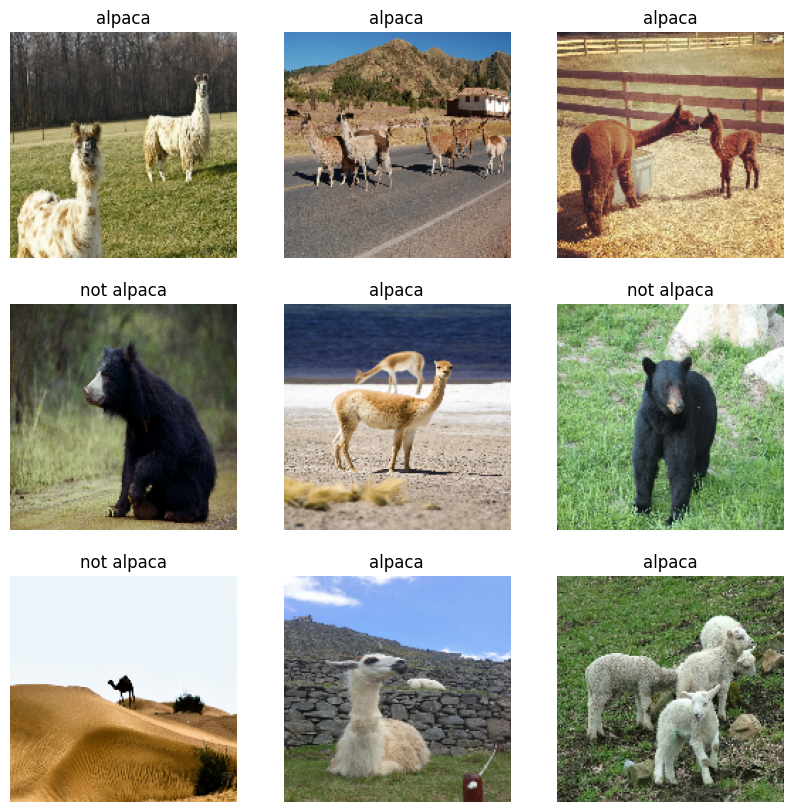

In [4]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## Preprocess and Augment Training Data

Using `prefetch()` prevents a memory bottleneck that can occur when reading from disk. It sets aside some data and keeps it ready for when it's needed, by creating a source dataset from input data, applying a transformation to preprocess it, then iterating over the dataset one element at a time. Since, the dataset is streaming, the data doesn't need to fit into memory.

Number of elements to prefetch can be set manually, or we can use `tf.data.experimental.AUTOTUNE` to chose the parameters experimentally. Autotune prompts `tf.data` to tune that value dynamically at runtime, by tracking the time spent in each operation and feeding those time into an optimization algorithm. The optimization algorithm tries to find the best allocation of its CPU budget across all tunable operations.

To increase diversity in the training set and help our model learn the data better, it's standard practice to augment the images by transforming them, i.e., randomly flipping and rotating them. Keras' Sequential API offers a straightforward method for these kinds of data augmentation, with buil-in, customizable preprocessing layers. These layers are saved with the rest of our model and can be re-used later.

In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

## Data Augmentation

In [6]:
def data_augmenter():
    '''
    Create a Sequential model composed of 2 layers.

    Returns:
        tf.keras.Sequential
    '''

    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip('horizontal'))
    data_augmentation.add(RandomRotation(0.2))

    return data_augmentation

Taking a look at how an image from the training set has been augmented with simple transformations:

From one cute animal, to 9 variations of the cute animal. Now our model has a lot more to learn from.

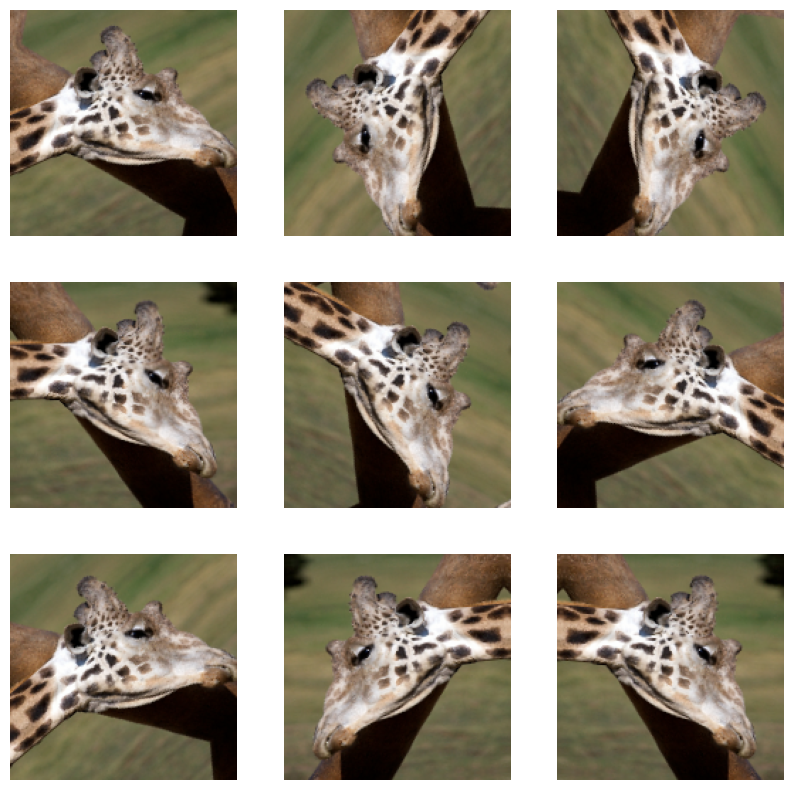

In [9]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10,10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255.0)
        plt.axis('off')

Now, we can use our tool from MobileNet application in TensorFlow, to normalize our input.